In [1]:
import numpy as np
import numpy.linalg as la
import cvxpy as cp
import matplotlib.pyplot as plt
import math
import random
import time
import mosek

import warnings
warnings.filterwarnings('ignore')

seed=0
random.seed(a=seed)
np.random.seed(seed=seed)

def relu(x):
    return np.maximum(0,x)
def drelu(x):
    return x>=0

In [2]:
import matplotlib.colors as mcolors

In [3]:
RANDOM_STATE = 0

### 1. Data Generation

In [4]:
def spiral_xy(i, total_points, spiral_num, n_shape = 50):
    """
    Create the data for a normalized spiral.

    Arguments:
        i runs from 0 to total_points-1.
        total_points is the total number of points in the spiral.
        spiral_num is 1 or -1.
        n_shape is an int which determines the shape of spiral wrt function, unscaled_spiral_xy.
    """
    # Normalize i to always fit in the range [0, 96], which is the original range.
    i_normalized = i * n_shape / (total_points - 1)
    φ = i_normalized / 16 * math.pi
    r = 6.5 * ((104 - i_normalized) / 104)
    x = (r * math.cos(φ) * spiral_num) / 13 + 0.5
    y = (r * math.sin(φ) * spiral_num) / 13 + 0.5  # spiral_num mirrors the orientation of the spiral
    return (x, y)


def spiral(spiral_num, n=100, n_shape = 50):
    """
    Generate either a clockwise (+1) spiral or a counter clockwise (-1) spiral for a total of n points.

    Arguments:
        spiral_num: 1 or -1 determines the orientation of the spiral.
        n: total number of points in a spiral.
    """
    return [spiral_xy(i, n, spiral_num, n_shape) for i in range(n//2)]


def generate_spiral_data(n=100, n_train = 80, n_shape = 50, seed = RANDOM_STATE, default_label = True):
    """
    Generate binary spiral classification data.

    Arguments:
        n: total number of points in a spiral.
        n_train: numbr of training points.
        seed: permutation randomization seed.
        default_label: True uses label +/-1 and False uses label 0/1
    """
    a = spiral(1,n,n_shape)
    b = spiral(-1,n,n_shape)
    # Combine spiral from both orientation as one and scaling feature space from (0,1)^2 to (-1,1)^2
    X_all=2*np.concatenate((a,b),axis=0)-1 
    X_all=np.append(X_all,np.ones((n,1)),axis=1) # Adding bias to the feature space
    # concatenate the labels of the spiral, which is their orientation (+1/-1)
    if default_label:
        y_all=np.concatenate((np.ones(n//2),-np.ones(n//2))) 
    else:
        y_all=np.concatenate((np.ones(n//2),np.zeros(n//2))) # reset -1 to 0.
    # randomize data indices
    np.random.seed(seed)
    idx = np.random.permutation(n)
    X_all = X_all[idx]
    y_all = y_all[idx]
    # Split into training and testing sets
    X_train, y_train = X_all[:n_train], y_all[:n_train]
    X_test, y_test = X_all[n_train:], y_all[n_train:]
    
    return X_all, y_all, X_train, y_train, X_test, y_test


In [5]:
X_all, y_all, X, y, Xacc, yacc = generate_spiral_data()

### 2. Hyperplane partitions sampling

In [6]:
beta=1e-5
P=1000
n = 80
d = 3
np.random.seed(RANDOM_STATE)
dmat=np.empty((n,0))

## Finite approximation of all possible sign patterns
for i in range(P):
    u=np.random.randn(d,1)
    dmat=np.append(dmat,drelu(np.dot(X,u)),axis=1)

dmat=(np.unique(dmat,axis=1))

In [7]:
dmat.shape

(80, 623)

### 3. Convex solver for exact convex program reformulation of two-layer ReLU NN

In [8]:
# Optimal CVX
m=dmat.shape[1]
Uopt1=cp.Variable((d,m)) # c_i in paper
Uopt2=cp.Variable((d,m)) # c_i' in paper

## Below we use hinge loss as a performance metric for binary classification
yopt1=cp.Parameter((n,1))
yopt2=cp.Parameter((n,1))
yopt1=cp.sum(cp.multiply(dmat,(X*Uopt1)),axis=1)
yopt2=cp.sum(cp.multiply(dmat,(X*Uopt2)),axis=1)
#cost=cp.sum(cp.pos(1-cp.multiply(y,yopt1-yopt2)))/n+beta*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))
cost=cp.sum_squares(y-(yopt1-yopt2))/(2*n)+beta*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))

constraints=[]
constraints+=[cp.multiply((2*dmat-np.ones((n,m))),(X*Uopt1))>=0]
constraints+=[cp.multiply((2*dmat-np.ones((n,m))),(X*Uopt2))>=0]
prob=cp.Problem(cp.Minimize(cost),constraints)
prob.solve(solver=cp.CLARABEL,warm_start=True)
cvx_opt=prob.value
if prob.status != "optimal":
    print("Convex: Status convex: ",prob.status)
print("2-layer convex program objective value: ",cvx_opt)

2-layer convex program objective value:  0.0008144290287536936


### 4. Comparison of Convex Solver with SGD

Number of neurons: 623


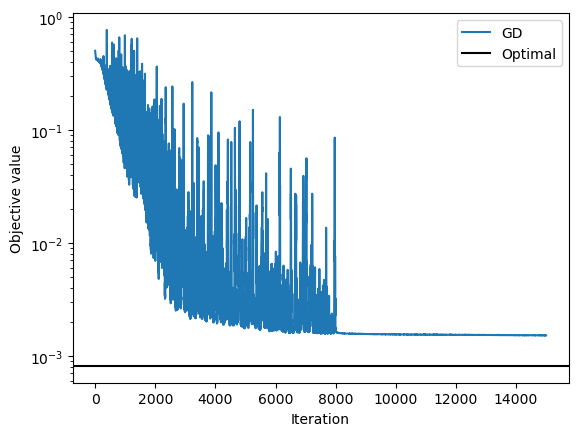

In [9]:
# BP
sigma=1e-2
mu=0.5
print("Number of neurons:",m)
mbp=2*m
ITERS=15000
U=sigma*np.random.randn(d,mbp)
w=sigma*np.random.randn(mbp,1)
yall=y.reshape(-1,1)
obj_bp=np.empty((ITERS,1))
batch_size=n
nb=batch_size
for i in range(ITERS):
    if i%8000 == 0 and i>0:
        mu=mu/5
    samp=np.random.choice(n,batch_size)
    Xgd=X[samp,:]
    ygd=yall[samp,:]
    a1=np.dot(Xgd,U)
    yest=np.dot(relu(a1),w)
    yest_all=np.dot(relu(np.dot(X,U)),w)
    obj_bp[i]=np.linalg.norm(yall-yest_all)**2/(2*n)+(beta/2)*(np.linalg.norm(U,'fro')**2+np.linalg.norm(w,'fro')**2)
    gradw= relu(a1).T@(yest-ygd)/nb
    gradU=np.zeros((d,mbp))

    gradU=Xgd.T@(drelu(a1)*((yest-ygd)@w.T))/nb

    U=(1-mu*beta)*U-mu*gradU
    w=(1-mu*beta)*w-mu*gradw


# Plot
plt.figure(0)
plt.semilogy(obj_bp,label='GD')
plt.axhline(cvx_opt,color='k',label='Optimal')
plt.ylabel('Objective value')
plt.xlabel('Iteration')
plt.savefig('bp_vs_cvx.pdf', bbox_inches='tight')

plt.legend();

In [10]:
### 4 (a). Plotting Decision boundaries: cvx (left); sgd (right).

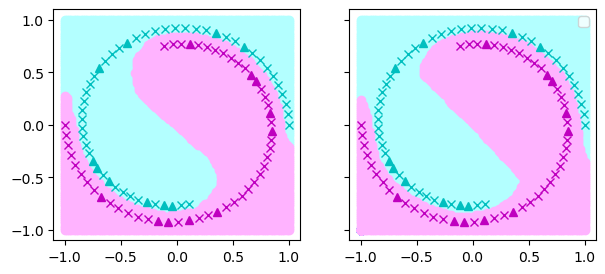

In [11]:
samp=100
x1=np.linspace(-1,1,samp).reshape(-1,1)
x2=np.linspace(-1,1,samp).reshape(-1,1)

Xtest=np.ones((samp**2,d))
count=0
for i in range(samp):
    for j in range(samp):
        Xtest[count]=[x1[i, 0],x2[j, 0],1]
        count+=1

ntest=Xtest.shape[0]

Uopt1v=Uopt1.value
Uopt2v=Uopt2.value

yest_cvx=np.sum(drelu(Xtest@Uopt1v)*(Xtest@Uopt1v)-drelu(Xtest@Uopt2v)*(Xtest@Uopt2v),axis=1)
yest_bp=np.dot(relu(np.dot(Xtest,U)),w)


pos_cvx=np.where(np.sign(yest_cvx)==1)
neg_cvx=np.where(np.sign(yest_cvx)==-1)
pos_bp=np.where(np.sign(yest_bp)==1)
neg_bp=np.where(np.sign(yest_bp)==-1)
pos=np.where(y==1)
neg=np.where(y==-1)
pos_test=np.where(yacc==1)
neg_test=np.where(yacc==-1)


def plot_result(pos1, neg1, pos2, neg2, name):

    def mix_with_white(color, alpha):
        white = np.array([1, 1, 1])
        return (1 - alpha) * white + alpha * np.array(color)

    # Define the original colors
    cyan = [0, 1, 1]
    magenta = [1, 0, 1]

    # Mix the colors with white
    cyan_mixed = mix_with_white(cyan, 0.3)
    magenta_mixed = mix_with_white(magenta, 0.3)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

    ax1.plot(Xtest[pos1,0],Xtest[pos1,1],'o', label = 'Train data', color=cyan_mixed);
    ax1.plot(Xtest[neg1,0],Xtest[neg1,1],'o', label = 'Test data', color=magenta_mixed);
    ax1.plot(X[pos,0],X[pos,1],'cx');
    ax1.plot(X[neg,0],X[neg,1],'mx');
    ax1.plot(Xacc[pos_test,0],Xacc[pos_test,1],'cx',marker ='^');
    ax1.plot(Xacc[neg_test,0],Xacc[neg_test,1],'mx',marker ='^');
        

    ax2.set_yticklabels([])

    ax2.plot(Xtest[pos2,0],Xtest[pos2,1],'o', color=cyan_mixed);
    ax2.plot(Xtest[neg2,0],Xtest[neg2,1],'o', color=magenta_mixed);
    ax2.plot(X[pos,0],X[pos,1],'cx');
    ax2.plot(X[neg,0],X[neg,1],'mx');
    ax2.plot(Xacc[pos_test,0],Xacc[pos_test,1],'cx',marker ='^');
    ax2.plot(Xacc[neg_test,0],Xacc[neg_test,1],'mx',marker ='^');
    
    plt.legend()

    plt.savefig(f'{name}.pdf', bbox_inches='tight')


plot_result(pos_cvx, neg_cvx, pos_bp, neg_bp, 'full_data')

In [12]:
# Another way of plotting decision boundary of cvx

In [13]:
def plot_decision_boundary(X, y, X_test, y_test, Uopt1v, Uopt2v, selected_indices, name):
    # Define the grid range based on the data range
    x_min, x_max = -1.5, 1.5 # 1.5
    y_min, y_max = -1.5, 1.5

    # Create a grid of points
    x1 = np.linspace(x_min, x_max, 100)
    x2 = np.linspace(y_min, y_max, 100)
    x1, x2 = np.meshgrid(x1, x2)
    Xtest = np.c_[x1.ravel(), x2.ravel()]
    Xtest = np.append(Xtest, np.ones((Xtest.shape[0], 1)), axis=1)  # Add the bias term
    
    yest_cvx=np.sum(drelu(Xtest@Uopt1v)*(Xtest@Uopt1v)-drelu(Xtest@Uopt2v)*(Xtest@Uopt2v),axis=1)
    yest_cvx = yest_cvx.reshape(x1.shape)
    
    # Map labels back to -1 and 1 for visualization
    y_train_mapped = np.where(y == 1, 1, -1)
    y_test_mapped = np.where(y_test == 1, 1, -1)
    
    X_selected = X[selected_indices]
    y_selected = y_train_mapped[selected_indices]

    # Create subplots
    fig, ax = plt.subplots(figsize=(7, 7))

    # Define the custom colors
    colors = ['#920783', '#00b7c7']  # Switched the colors to match the image
    cmap = mcolors.ListedColormap(colors)

    # Plot the decision boundary with custom colors
    ax.contourf(x1, x2, yest_cvx, alpha=0.3, cmap=cmap)
    scatter_train = ax.scatter(X[:, 0], X[:, 1], c=y_train_mapped, edgecolor='k', s=20, cmap=cmap,
                               label='Train Data')
    scatter_test = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test_mapped, edgecolor='k', s=20, cmap=cmap,
                              marker='^', label = 'Test Data')
    scatter_select = ax.scatter(X_selected[:,0], X_selected[:,1], c=y_selected, s=80, cmap=cmap, marker='x',
                               label='Queried Data')
    
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'{name}')
    plt.legend()
    #plt.savefig(f'{name}.pdf', bbox_inches='tight')
    plt.show()

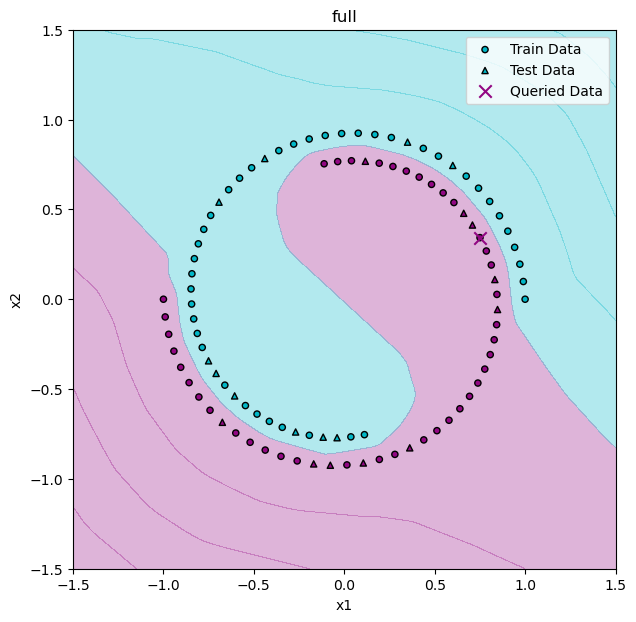

In [14]:
plot_decision_boundary(X, y, Xacc, yacc, Uopt1v, Uopt2v, [1], 'full')

In [15]:
# Accuracy rate

In [16]:
yacc_cvx = np.sign(np.sum(drelu(Xacc@Uopt1v)*(Xacc@Uopt1v)-drelu(Xacc@Uopt2v)*(Xacc@Uopt2v),axis=1))
yacc_bp = np.sign(np.dot(relu(np.dot(Xacc,U)),w))

acc_cvx = np.sum(yacc_cvx == yacc) / len(yacc)
acc_bp = np.sum(yacc_bp.flatten() == yacc) / len(yacc)

print(f'accuracy cvx: {acc_cvx}, accuracy bp: {acc_bp}')

accuracy cvx: 1.0, accuracy bp: 1.0


### 5. Cutting-plane AL via a Two-layer ReLU NN

In [17]:
N = len(y)

In [18]:
def sign(a):
    return 2 * int(a >= 0) - 1

In [19]:
# compute analytic center
def center(S, R=1, boxinit=False, reg=False, reg_value=2e-4):
    """S is list of affine inequalities described as tuple of LHS vector/matrix and RHS scalar/vector"""
    s = cp.Variable(2*d*m)
    obj = 0 if boxinit else cp.log(R - cp.norm(s))
    constraints = []
    if reg:
        U = cp.reshape(s, (2*d, m), order='F')
        #obj += cp.log(reg_value - beta*(cp.mixed_norm(U[:d].T,2,1)+cp.mixed_norm(U[d:].T,2,1)))
        constraints = [beta*(cp.mixed_norm(U[:d].T,2,1)+cp.mixed_norm(U[d:].T,2,1)) <= reg_value]
    if len(S) > 0:
        obj += cp.sum([cp.log(rhs - lhs @ s) for lhs, rhs in S])
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve(solver=cp.MOSEK)
    return s.value

In [20]:
# cut set
def cut(S, x, y, dmat_row):
    m = len(dmat_row)
    # f = cp.sum(cp.multiply(dmat, X*(Uopt1 - Uopt2)), axis=1)
    # f_i = dmat[i, 0] * X[i, :] [I - I] var[:, 0] + dmat[i, 1] * X[i, :] [I - I] var[:, 1] + ...  where var = [Uopt1; Uopt2]
    # f_i = dmat[i, :] @ [X[i, :] [I - I] var[:, 0]; X[i, :] [I - I] var[:, 1]; ...]
    S.append((-y * dmat_row @ np.kron(np.eye(m), np.concatenate((x, -x)).T), 0))

    relu_constraint = -np.kron(np.diag(2*dmat_row-np.ones(m)), np.kron(np.eye(2), x))
    for lhs in relu_constraint:
        S.append((lhs, 0))
    # potentially remove redundant constraints here

In [21]:
def pred_point(i, U1v, U2v): # corresponds to <w(theta), x>
    y1 = np.sum(np.multiply(dmat[i],(X[i][np.newaxis, :] @ U1v)),axis=1)
    y2 = np.sum(np.multiply(dmat[i],(X[i][np.newaxis, :] @ U2v)),axis=1)
    return y1 - y2

def pred_point_simplified(i, U1v, U2v):
    var = np.vstack((U1v, U2v)).flatten(order='F')
    return (dmat[i] @ np.kron(np.eye(len(dmat[i])), np.concatenate((X[i], -X[i])).T)) @ var

def pred_point_simplified_vec(i, vec):
    return (dmat[i] @ np.kron(np.eye(len(dmat[i])), np.concatenate((X[i], -X[i])).T)) @ vec

In [22]:
def constraint(i, U1v, U2v):
    return np.vstack((
        np.multiply((2*dmat[i]-np.ones((1,m))),(X[i] @ U1v)),
        np.multiply((2*dmat[i]-np.ones((1,m))),(X[i] @ U2v))
    )).flatten(order='F')

def constraint_simplified(i, U1v, U2v):
    var = np.vstack((U1v, U2v)).flatten(order='F')
    return np.kron(np.diag(2*dmat[i]-np.ones(m)), np.kron(np.eye(2), X[i])) @ var

In [23]:
def in_Ct(c, Ct, eps=1e-3):
    for lhs, rhs in Ct:
        if lhs @ c > rhs + eps:
            return False
    return True

In [24]:
def sample_lattice(S, R=1):
    d = 3
    l = cp.Variable(2*d*m)
    d = np.random.randn(2*d*m)
    obj = (d / np.linalg.norm(d)) @ l
    prob = cp.Problem(cp.Maximize(obj), [cp.norm(l) <= R] + [lhs @ l <= rhs for lhs, rhs in S])
    prob.solve(cp.MOSEK)
    return l.value

In [25]:
R = 1

C0_lower = -R*np.ones(2*d*m)
C0_upper = R*np.ones(2*d*m)

def sample_classifier(Ct, c, maxiter=10**5):
    for _ in range(maxiter):
        #candidate = np.random.uniform(C0_lower, C0_upper)
        candidate = c + np.random.randn(*c.shape)
        if in_Ct(candidate, Ct):
            return candidate
    print(f'Failed to sample after {maxiter} tries.')
    return None

In [26]:
def query(C, c, data_tried, data_used, M=100):

    mini = np.inf
    i_mini = -1

    maxi = -np.inf
    i_maxi = -1

    minabs = np.inf
    i_minabs = -1

    #theta_s = np.zeros(2*d*m)
    #for _ in range(M):
    #    th = sample_classifier(C, c)
    #    #th = sample_lattice(C)
    #    if th is None:
    #        return None, None, None
    #    theta_s += (1/M) * th

    #theta_matrix = np.reshape(c, (2*d, m), order='F')
    #U1_query=theta_matrix[:d]
    #U2_query=theta_matrix[d:]

    for i in range(N): # search in finite data (D implicit) set to re-use dmat then
        if i not in data_tried and i not in data_used:
            pred = pred_point_simplified_vec(i, c)
            if pred < mini:
                i_mini = 1*i
                mini = pred
            if pred > maxi:
                i_maxi = 1*i
                maxi = pred
            if abs(pred) < minabs:
                i_minabs = 1*i
                minabs = abs(pred)

    return i_mini, i_maxi, i_minabs

In [27]:
# final convex solve

def convex_solve(used):

    used_unique = list(set(used))

    Uopt1_final=cp.Variable((d,m)) # c_i in paper
    Uopt2_final=cp.Variable((d,m)) # c_i' in paper

    yopt1_final=cp.sum(cp.multiply(dmat[used_unique],(X[used_unique]*Uopt1_final)),axis=1)
    yopt2_final=cp.sum(cp.multiply(dmat[used_unique],(X[used_unique]*Uopt2_final)),axis=1)

    cost=cp.sum_squares(y[used_unique]-(yopt1_final-yopt2_final))/(2*n)+beta*(cp.mixed_norm(Uopt1_final.T,2,1)+cp.mixed_norm(Uopt2_final.T,2,1))

    constraints=[]
    constraints+=[cp.multiply((2*dmat[used_unique]-np.ones((len(used_unique),m))),(X[used_unique]*Uopt1_final))>=0]
    constraints+=[cp.multiply((2*dmat[used_unique]-np.ones((len(used_unique),m))),(X[used_unique]*Uopt2_final))>=0]
    prob_final=cp.Problem(cp.Minimize(cost),constraints)
    prob_final.solve(solver=cp.CLARABEL,warm_start=True)

    return Uopt1_final.value, Uopt2_final.value, beta*(cp.mixed_norm(Uopt1_final.value.T,2,1)+cp.mixed_norm(Uopt2_final.value.T,2,1))

In [33]:
# cutting plane method

def cutting_plane(n_points=100, maxit=10000, boxinit=False):
    
    data_tried = []
    data_used = []
    
    Ct = []
    if boxinit:
        for i, (l, u) in enumerate(zip(C0_lower, C0_upper)):
            one_vec = np.zeros(2*d*m)
            one_vec[i] = 1
            Ct.append((one_vec, u))
            Ct.append((-one_vec, -l))
    
    c = None
    did_cut = True
    it = 0
    while len(data_used) < n_points and it < maxit: # TODO: replace by proper termination criterion
        if len(data_tried) == N:
            data_tried = []
        if did_cut:
            #if len(data_used) > 0:
            #    _, _, reg_value = convex_solve(data_used)
            #else:
            #    reg_value = 1e-5
            c = center(Ct, R=R)
            did_cut = False
        i_mini, i_maxi, i_minabs = query(Ct, c, data_tried, data_used)
        if i_mini is None:
            return Ct, c, data_used
        data_tried += [i_mini, i_maxi]
        data_tried = list(set(data_tried))
        #if it >= 30:
        #    print(X[i_mini], np.sign(pred_point_simplified_vec(i_mini, c)), y[i_mini])
        #    print(X[i_maxi], np.sign(pred_point_simplified_vec(i_maxi, c)), y[i_maxi])
            #print(X[i_minabs], np.sign(pred_point_simplified_vec(i_minabs, c)), y[i_minabs])
        if True: #len(data_used) < 4 * n_points // 5:
            if np.sign(pred_point_simplified_vec(i_mini, c)) != y[i_mini]:
                print(f'Cutting at iteration {it}')
                cut(Ct, X[i_mini], y[i_mini], dmat[i_mini])
                data_used.append(i_mini)
                did_cut = True
            if np.sign(pred_point_simplified_vec(i_maxi, c)) != y[i_maxi]:
                print(f'Cutting at iteration {it}')
                cut(Ct, X[i_maxi], y[i_maxi], dmat[i_maxi])
                data_used.append(i_maxi)
                did_cut = True
        else:
            if np.sign(pred_point_simplified_vec(i_minabs, c)) != y[i_minabs]:
                print(f'Cutting at iteration {it}')
                cut(Ct, X[i_minabs], y[i_minabs], dmat[i_minabs])
                data_used.append(i_minabs)
                did_cut = True
        it += 1
        
        #data_used = list(set(data_used))
        
        #print(len(data_tried))
    
    return Ct, c, data_used

In [35]:
C, c, used = cutting_plane(20)
print(f'size of C: {len(C)}')
print(f'used: {used}')

Cutting at iteration 0
Cutting at iteration 0
Cutting at iteration 1
Cutting at iteration 8
Cutting at iteration 16
Cutting at iteration 16
Cutting at iteration 17
Cutting at iteration 21
Cutting at iteration 24
Cutting at iteration 25
Cutting at iteration 25
Cutting at iteration 27
Cutting at iteration 29
Cutting at iteration 35
Cutting at iteration 35
Cutting at iteration 40
Cutting at iteration 40
Cutting at iteration 43
Cutting at iteration 48
Cutting at iteration 63
size of C: 24940
used: [0, 0, 29, 55, 25, 27, 2, 65, 13, 18, 30, 5, 47, 14, 3, 52, 52, 62, 46, 28]


In [41]:
def visualize(Uopt1v_list, Uopt2v_list, title):

    pos_cvx = []
    neg_cvx = []
    
    for Uopt1v, Uopt2v in zip(Uopt1v_list, Uopt2v_list):
    
        yest_cvx=np.sum(drelu(Xtest@Uopt1v)*(Xtest@Uopt1v)-drelu(Xtest@Uopt2v)*(Xtest@Uopt2v),axis=1)
        pos_cvx.append(np.where(np.sign(yest_cvx)==1))
        neg_cvx.append(np.where(np.sign(yest_cvx)==-1))
        
        yacc_cvx = np.sign(np.sum(drelu(Xacc@Uopt1v)*(Xacc@Uopt1v)-drelu(Xacc@Uopt2v)*(Xacc@Uopt2v),axis=1))
        print(f'# of correct classificationsn on the test set: {np.sum(yacc_cvx == yacc)}')
        acc_cvx = np.sum(yacc_cvx == yacc) / len(yacc)
        print(f'accuracy cvx on the test set: {acc_cvx}')

        ytrain_cvx = np.sign(np.sum(drelu(X@Uopt1v)*(X@Uopt1v)-drelu(X@Uopt2v)*(X@Uopt2v),axis=1))
        print(f'# of correct classificationsn on the train set: {np.sum(ytrain_cvx == y)}')
        acc_train = np.sum(ytrain_cvx == y) / len(y)
        print(f'accuracy cvx on the train set: {acc_train}')

    plot_result(pos_cvx[0], neg_cvx[0], pos_cvx[1], neg_cvx[1], title)

In [39]:
def visualize_boundary(Uopt1v_list, Uopt2v_list, title):
    
    for Uopt1v, Uopt2v in zip(Uopt1v_list, Uopt2v_list):
    
        yest_cvx=np.sum(drelu(Xtest@Uopt1v)*(Xtest@Uopt1v)-drelu(Xtest@Uopt2v)*(Xtest@Uopt2v),axis=1)
        
        yacc_cvx = np.sign(np.sum(drelu(Xacc@Uopt1v)*(Xacc@Uopt1v)-drelu(Xacc@Uopt2v)*(Xacc@Uopt2v),axis=1))
        print(f'# of correct classificationsn on the test set: {np.sum(yacc_cvx == yacc)}')
        acc_cvx = np.sum(yacc_cvx == yacc) / len(yacc)
        print(f'accuracy cvx on the test set: {acc_cvx}')

        ytrain_cvx = np.sign(np.sum(drelu(X@Uopt1v)*(X@Uopt1v)-drelu(X@Uopt2v)*(X@Uopt2v),axis=1))
        print(f'# of correct classificationsn on the train set: {np.sum(ytrain_cvx == y)}')
        acc_train = np.sum(ytrain_cvx == y) / len(y)
        print(f'accuracy cvx on the train set: {acc_train}')

    plot_result(pos_cvx[0], neg_cvx[0], pos_cvx[1], neg_cvx[1], title)

# of correct classificationsn on the test set: 12
accuracy cvx on the test set: 0.6
# of correct classificationsn on the train set: 67
accuracy cvx on the train set: 0.8375
# of correct classificationsn on the test set: 20
accuracy cvx on the test set: 1.0
# of correct classificationsn on the train set: 80
accuracy cvx on the train set: 1.0


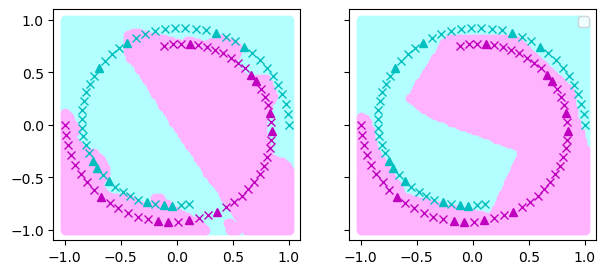

In [42]:
theta_matrix = np.reshape(c, (2*d, m), order='F')
Uopt1_final_v, Uopt2_final_v, _ = convex_solve(used)
visualize([theta_matrix[:d], Uopt1_final_v], [theta_matrix[d:], Uopt2_final_v], 'norefine')

### 6. Linear cutting-plane AL method

In [48]:
N = 80

In [49]:
d=3

In [50]:
def linear_center(S, R=1):
    """S is a list of affine inequalities described as (LHS vector, RHS scalar) tuples."""
    w = cp.Variable(d)
    obj = cp.log(R - cp.norm(w)) # Objective for finding the center (log-barrier)
    constraints = []
    
    if len(S) > 0:
        obj += cp.sum([cp.log(rhs - lhs @ w) for lhs, rhs in S])  # Add log-barrier constraints

    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve(solver=cp.MOSEK)
    
    return w.value  # Return the center of the current feasible region

In [51]:
def linear_query(w, X, y, data_tried, data_used, M=100):

    mini = np.inf
    i_mini = -1

    maxi = -np.inf
    i_maxi = -1

    minabs = np.inf
    i_minabs = -1
    
    for i in range(N): # search in finite data (D implicit) set to re-use dmat then
        if i not in data_tried and i not in data_used:
            pred = y[i] * np.dot(w, X[i])
            if pred < mini:
                i_mini = 1*i
                mini = pred
            if pred > maxi:
                i_maxi = 1*i
                maxi = pred
            if abs(pred) < minabs:
                i_minabs = 1*i
                minabs = abs(pred)

    return i_mini, i_maxi, i_minabs

In [52]:
def linear_cut(S, x, y):
    """
    Add a new cutting-plane constraint for a linear classifier.
    
    Arguments:
    - S: current list of constraints
    - x: the feature vector of the queried point
    - y: the label of the queried point
    """
    # The constraint is simply: y * <w, x> >= 0, which means adding (y * x, 0) to the constraint set
    S.append((y * x, 0))  # Add new constraint y * <w, x> >= 0

In [53]:
R = 1

C0_lower_linear = -R*np.ones(d)
C0_upper_linear = R*np.ones(d)

In [54]:
def linear_cutting_plane(n_points=100, maxit=10000, boxinit=False):

    data_tried = []
    data_used = []

    Ct = []
    if boxinit:
        for i, (l, u) in enumerate(zip(C0_lower_linear, C0_upper_linear)):
            one_vec = np.zeros(d)
            one_vec[i] = 1
            Ct.append((one_vec, u))
            Ct.append((-one_vec, -l))

    c = None
    did_cut = True
    it = 0
    #print(it)
    #print(len(data_used))
    while len(data_used) < n_points and it < maxit: 
        if len(data_tried) == N:
            data_tried = []
        if did_cut:
            c = linear_center(Ct, R=R) # cannot be 0
            # Offset the center if it's too close to zero
            if np.all(np.abs(c) < 1e-6):  # If all values of `c` are very close to zero
                c += 1e-6 * np.random.randn(d)  # Apply small random offset
            #print(c)
            did_cut = False
        i_mini, i_maxi, i_minabs = linear_query(c, X, y, data_tried, data_used)
        if i_mini is None:
            return Ct, c, data_used
        data_tried += [i_mini, i_maxi]
        data_tried = list(set(data_tried))
        if True: 
            if y[i_mini]*np.dot(c,X[i_mini]) < 0:
                #print(1,'y')
                #print(f'Cutting at iteration {it}')
                linear_cut(Ct, X[i_mini], y[i_mini])
                data_used.append(i_mini)
                did_cut = True
            if y[i_maxi]*np.dot(c,X[i_maxi]) < 0:
                #print(2,'y')
                #print(f'Cutting at iteration {it}')
                linear_cut(Ct, X[i_maxi], y[i_maxi])
                data_used.append(i_maxi)
                did_cut = True
        else:
            if y[i_minabs]*np.dot(c,X[i_minabs])<0:
                #print(3,'y')
                #print(f'Cutting at iteration {it}')
                linear_cut(Ct, X[i_minabs], y[i_minabs])
                data_used.append(i_minabs)
                did_cut = True
        it += 1

        #data_used = list(set(data_used))

        #print(len(data_tried))

    return Ct, c, data_used

In [27]:
C, c, used = linear_cutting_plane(20)
print(f'size of C: {len(C)}')
print(f'used: {used}')

Cutting at iteration 0
Cutting at iteration 1
Cutting at iteration 2
Cutting at iteration 3
Cutting at iteration 4
Cutting at iteration 5
Cutting at iteration 6
Cutting at iteration 7
Cutting at iteration 8
Cutting at iteration 9
Cutting at iteration 10
Cutting at iteration 11
Cutting at iteration 12
Cutting at iteration 13
Cutting at iteration 14
Cutting at iteration 15
Cutting at iteration 16
Cutting at iteration 17
Cutting at iteration 18
Cutting at iteration 19
size of C: 20
used: [57, 53, 18, 66, 61, 15, 71, 54, 35, 0, 17, 58, 16, 76, 70, 36, 46, 6, 45, 68]


In [68]:
def cal_linear_acc(X, y, X_test, y_test, itr_ls):
    acc_linear_train = []
    acc_linear_test = []
    for i in range(len(itr_ls)):
        C, c, used = linear_cutting_plane(itr_ls[i])
        y_pred_train = np.sign(np.dot(X, c))
        y_pred_test = np.sign(np.dot(X_test, c))
        accuracy_train = np.sum(y_pred_train == y) / len(y)
        accuracy_test = np.sum(y_pred_test == y_test) / len(y_test)
        acc_linear_train.append(accuracy_train)
        acc_linear_test.append(accuracy_test)
    return acc_linear_train, acc_linear_test

In [33]:
def plot_decision_boundary_linear(X, y, X_test, y_test, c, selected_indices, name):
    # Define the grid range based on the data range
    x_min, x_max = -1.5, 1.5 # 1.5
    y_min, y_max = -1.5, 1.5

    # Create a grid of points
    x1 = np.linspace(x_min, x_max, 100)
    x2 = np.linspace(y_min, y_max, 100)
    x1, x2 = np.meshgrid(x1, x2)
    Xtest = np.c_[x1.ravel(), x2.ravel()]
    Xtest = np.append(Xtest, np.ones((Xtest.shape[0], 1)), axis=1)  # Add the bias term
    
    # Predict the labels for both training and test data
    y_pred_train = np.sign(np.dot(X, c))  # Predictions for training data
    y_pred_test = np.sign(np.dot(X_test, c))  # Predictions for test data
    y_pred_all = np.sign(np.dot(X_all,c))
    y_pred_1 = np.sign(np.dot(Xtest,c))
    y_pred_1 = y_pred_1.reshape(x1.shape)
    
    # Map labels back to -1 and 1 for visualization
    y_train_mapped = np.where(y == 1, 1, -1)
    y_test_mapped = np.where(y_test == 1, 1, -1)

    # Compute accuracy on training and test sets
    accuracy_train = np.sum(y_pred_train == y) / len(y)
    accuracy_test = np.sum(y_pred_test == y_test) / len(y_test)

    print(f'Accuracy on training set: {accuracy_train * 100:.2f}%')
    print(f'Accuracy on test set: {accuracy_test * 100:.2f}%')
    
    X_selected = X[selected_indices]
    y_selected = y_train_mapped[selected_indices]

    # Create subplots
    fig, ax = plt.subplots(figsize=(7, 7))

    # Define the custom colors
    colors = ['#920783', '#00b7c7']  # Switched the colors to match the image
    cmap = mcolors.ListedColormap(colors)

    # Plot the decision boundary with custom colors
    ax.contourf(x1, x2, y_pred_1, alpha=0.3, cmap=cmap)
    scatter_train = ax.scatter(X[:, 0], X[:, 1], c=y_train_mapped, edgecolor='k', s=20, cmap=cmap,
                               label='Train Data')
    scatter_test = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test_mapped, edgecolor='k', s=20, cmap=cmap,
                              marker='^', label = 'Test Data')
    scatter_select = ax.scatter(X_selected[:,0], X_selected[:,1], c=y_selected, s=80, cmap=cmap, marker='x',
                               label='Queried Data')
    
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'{name}')
    plt.legend()
    plt.savefig(f'{name}.pdf', bbox_inches='tight')
    plt.show()

Accuracy on training set: 50.00%
Accuracy on test set: 50.00%


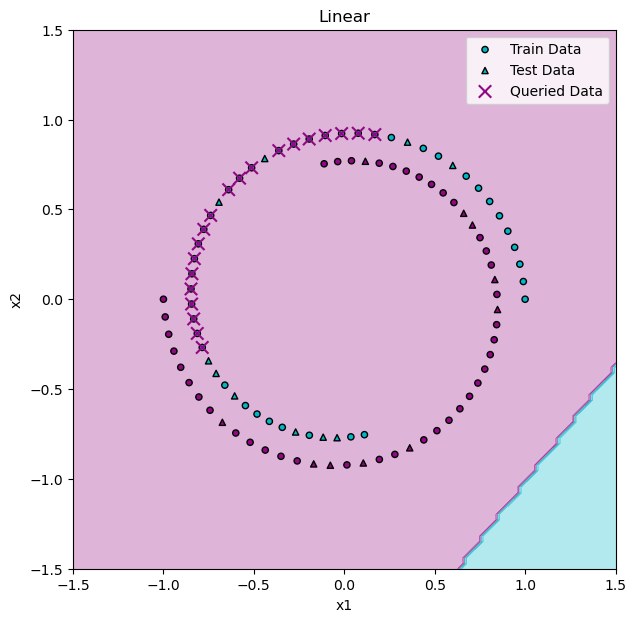

In [34]:
plot_decision_boundary_linear(X, y, Xacc, yacc, c, used, 'Linear')